## Настройка и импорт

In [8]:
import os
import json
import glob
import random
import shutil
import zipfile
import numpy as np
import pandas as pd
import datetime as dt
from pathlib import Path

from PIL import Image, ImageDraw
from tqdm import tqdm

import torch
import open_clip

# PytorchWildlife (MegaDetector v5)
from PytorchWildlife.models import detection as pw_detection
from PytorchWildlife import utils as pw_utils 

from sklearn.metrics import accuracy_score

/Users/antonsotnikov/Обучение-изучение/skillfactory/ML алгоритмы/project/project_venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import plotly.io as pio

pd.options.plotting.backend = "plotly"
pio.renderers.default = "notebook"

### Настройка констант, пути для данных

In [38]:
TEST_IMAGES_DIR = "data/camera_trap/camera_trap_dataset/test/images"
TEST_LABELS_DIR = "data/camera_trap/camera_trap_dataset/test/labels"
FULL_DATA_IMAGES_DIR = "data/camera_trap/camera_trap_dataset/full_dataset/images"
FULL_DATA_LABELS_DIR = "data/camera_trap/camera_trap_dataset/full_dataset/labels"

# Ниже данные для превью того как можно использовать модель в мониторинге
MONITORING_IMAGES_DIR = 'for_monitoring/images'
MONITORING_LABELS_DIR = 'for_monitoring/labels' 

# Путь хранения мета данных с камер (Дата-время, локации, айди фреймов)
META_JSON_PATH  = "wcs_camera_traps.json"

DET_CONF_THR = 0.2
IOU_THR_DET  = 0.5
IOU_THR_E2E  = 0.5

BIOCLIP_BS = 12
DEVICE = torch.device("mps") # Если используется macbook - оставляем как есть, в противном случае либо cuda, cpu

In [6]:
img_paths = sorted(glob.glob(os.path.join(TEST_IMAGES_DIR, "*")))
lbl_paths = sorted(glob.glob(os.path.join(TEST_LABELS_DIR, "*.txt")))

print("n_images:", len(img_paths))
print("n_label_files:", len(lbl_paths))
print("sample image:", img_paths[0] if img_paths else None)
print("sample label:", lbl_paths[0] if lbl_paths else None)


n_images: 2000
n_label_files: 2000
sample image: data/camera_trap/camera_trap_dataset/test/images/0058616c-92d5-11e9-ad83-000d3a74c7de.jpg
sample label: data/camera_trap/camera_trap_dataset/test/labels/0058616c-92d5-11e9-ad83-000d3a74c7de.txt


### Функции утилиты

In [7]:
def path_to_id(path):
    return os.path.basename(path).rsplit(".", 1)[0]

In [8]:
def read_yolo_labels(lbl_path):
    # Читает файл разметки YOLO (.txt) для одной картинки.
    # В YOLO каждая строка обычно такая:
    # class_id  x_center  y_center  width  height
    # где координаты и размеры НОРМАЛИЗОВАНЫ (в диапазоне 0..1) относительно ширины/высоты изображения.
    
    items = []
    if not os.path.exists(lbl_path) or os.path.getsize(lbl_path) == 0:
        return items
    with open(lbl_path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            cls, xc, yc, w, h = line.split()
            items.append((int(cls), float(xc), float(yc), float(w), float(h)))
    
    # Возвращаем список объектов:
    # [(cls, xc, yc, w, h), ]
    return items

def yolo_to_xyxy(xc, yc, w, h, W, H, pad=0.05):
    # Переводит YOLO-формат (xc, yc, w, h) в пиксельный bbox формата XYXY:
    # [x1, y1, x2, y2]
    #
    # YOLO хранит xc,yc,w,h в долях (0..1), поэтому умножаем на ширину/высоту картинки.
    # pad — небольшой отступ (например 5% от размеров bbox), чтобы кроп захватывал объект “с запасом”.
    
    bw, bh = w * W, h * H
    px, py = pad * bw, pad * bh
    x1 = (xc * W) - bw/2 - px
    y1 = (yc * H) - bh/2 - py
    x2 = (xc * W) + bw/2 + px
    y2 = (yc * H) + bh/2 + py
    x1 = max(0, int(x1)); y1 = max(0, int(y1))
    x2 = min(W-1, int(x2)); y2 = min(H-1, int(y2))
    return [x1, y1, x2, y2]

def iou_matrix(a, b):
    # Считает IoU (Intersection over Union) между всеми парами bbox из a и b.
    #
    # IoU = площадь пересечения / площадь объединения
    # Значения:
    # 0   -> вообще не пересекаются
    # 1   -> совпадают идеально
    #
    # a: numpy array shape (N,4)  bbox в формате xyxy
    # b: numpy array shape (M,4)  bbox в формате xyxy
    #
    # результат: матрица shape (N,M), где [i,j] = IoU(a[i], b[j])
    # Если один из списков пустой — возвращаем пустую матрицу нужного размера
    
    if len(a) == 0 or len(b) == 0:
        return np.zeros((len(a), len(b)), float)
    ax1, ay1, ax2, ay2 = a[:,0:1], a[:,1:2], a[:,2:3], a[:,3:4]
    bx1, by1, bx2, by2 = b[:,0],   b[:,1],   b[:,2],   b[:,3]
    ix1 = np.maximum(ax1, bx1); iy1 = np.maximum(ay1, by1)
    ix2 = np.minimum(ax2, bx2); iy2 = np.minimum(ay2, by2)
    iw = np.maximum(0.0, ix2 - ix1); ih = np.maximum(0.0, iy2 - iy1)
    inter = iw * ih
    area_a = np.maximum(0.0, ax2-ax1) * np.maximum(0.0, ay2-ay1)
    area_b = np.maximum(0.0, bx2-bx1) * np.maximum(0.0, by2-by1)
    return inter / (area_a + area_b - inter + 1e-9)

## Простой health-check данных

Быстро посмотрим на данные, на сами картинки и насколько лейблы отражают действительность

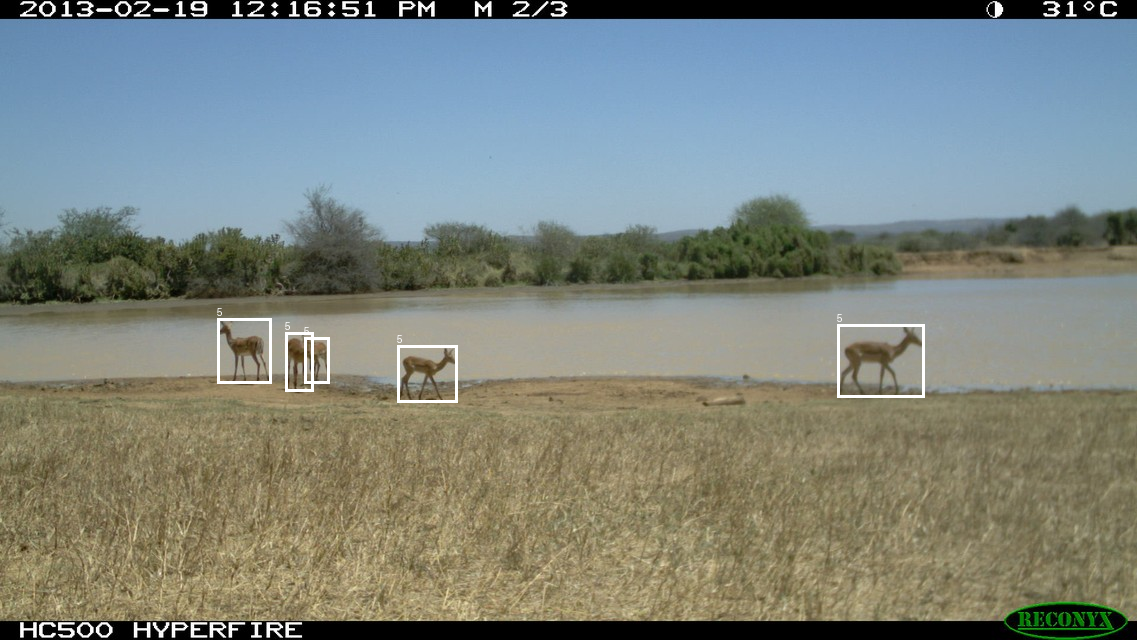

In [12]:
p = random.choice(img_paths)
img = Image.open(p).convert("RGB")
W, H = img.size

img_id = path_to_id(p)
lbl_path = os.path.join(TEST_LABELS_DIR, img_id + ".txt")
items = read_yolo_labels(lbl_path)

vis = img.copy()
draw = ImageDraw.Draw(vis)

for cls, xc, yc, w, h in items:
    x1,y1,x2,y2 = yolo_to_xyxy(xc,yc,w,h,W,H,pad=0.0)
    draw.rectangle([x1,y1,x2,y2], width=3)
    draw.text((x1, max(0,y1-12)), str(cls))

vis


Видно что лейблы хорошо и точно отражают реальность

В действительности в датасете так же присуствуют сложные фотографии со вспышками, ночные. Однако даже там лейблы отражены точно, полную проверку описывать тут не буду

## Работа с моделями

### Инцилизация детектора

Загружаем предобученный MegaDetectorV5. </br>
Важно: конструктор может инициализировать модель “по умолчанию” на CPU,

Дальше мы переключаем его уже на тот девайс который нам нужен

In [96]:
det_model = pw_detection.MegaDetectorV5(device="cpu", pretrained=True)

det_model.model = det_model.model.float().to(DEVICE)
det_model.device = DEVICE

print("model device:", next(det_model.model.parameters()).device)
print("model dtype:",  next(det_model.model.parameters()).dtype)   

Fusing layers... 
Model summary: 733 layers, 140054656 parameters, 0 gradients, 208.8 GFLOPs


model device: mps:0
model dtype: torch.float32


Используем без обучения сразу модель на нашей тестовой выборки

In [14]:
results_test = det_model.batch_image_detection(TEST_IMAGES_DIR, batch_size=8, det_conf_thres=DET_CONF_THR)

100%|████████████████████████████████████████████████████████████████| 250/250 [11:06<00:00,  2.67s/it]


In [99]:
def extract_det_boxes(result_item, det_conf_thr=0.2, animal_class_id=0):
    # Достаём предсказания детектора для одной картинки.
    
    dets = result_item["detections"]
    boxes = np.asarray(dets.xyxy, dtype=float)
    conf  = np.asarray(dets.confidence, dtype=float)
    clsid = np.asarray(dets.class_id, dtype=int)
    keep = (clsid == animal_class_id) & (conf >= det_conf_thr)
    return boxes[keep], conf[keep]

### Результаты детектора на тесте

In [16]:
TP=FP=FN=0

for r in tqdm(results_test, desc="Detector metrics"):
    img_path = r["img_id"]
    img_id = path_to_id(img_path)
    lbl_path = os.path.join(TEST_LABELS_DIR, img_id + ".txt")

    gt_items = read_yolo_labels(lbl_path)

    # если ground truth объектов нет — gt_boxes пустой
    if len(gt_items) == 0:
        gt_boxes = np.zeros((0,4), float)
    else:
        W, H = Image.open(img_path).size
        gt_boxes = np.array([yolo_to_xyxy(xc,yc,w,h,W,H,pad=0.0) for _,xc,yc,w,h in gt_items], float)

    det_boxes, _ = extract_det_boxes(r, det_conf_thr=DET_CONF_THR)

    ious = iou_matrix(gt_boxes, det_boxes)

    matched_det = set()
    for i in range(len(gt_boxes)):
        # если детекций вообще нет — все ground truth считаются как FN
        if len(det_boxes) == 0:
            FN += 1
            continue
        j = int(np.argmax(ious[i]))
        
        # если IoU достаточно большой и det bbox ещё не использовался — это TP
        if ious[i, j] >= IOU_THR_DET and j not in matched_det:
            TP += 1
            matched_det.add(j)
        # иначе этот ground truth bbox считаем пропущенным
        else:
            FN += 1

    FP += max(0, len(det_boxes) - len(matched_det))

# precision = доля правильных детекций среди всех детекций
# recall    = доля найденных объектов среди всех объектов в разметке
precision = TP / (TP+FP+1e-9)
recall    = TP / (TP+FN+1e-9)

det_metrics = {"TP":TP, "FP":FP, "FN":FN, "precision":precision, "recall":recall}
det_metrics


Detector metrics: 100%|██████████████████████████████████████████| 1986/1986 [00:00<00:00, 3059.81it/s]


{'TP': 3443,
 'FP': 201,
 'FN': 273,
 'precision': 0.9448408342478197,
 'recall': 0.9265339074270919}

Точность ~94.5% - почти все рамки, которые модель рисует как “животное”, действительно попадают в животное

Полнота ~92.7% - модель находит большую часть животных, но примерно 7% животных пропускает

Для предобученой модели и инференса - это хороший результат, идем дальше

### Инцилизация классификатора

In [17]:
model, _, preprocess = open_clip.create_model_and_transforms("hf-hub:imageomics/bioclip-2")
tokenizer = open_clip.get_tokenizer("hf-hub:imageomics/bioclip-2")

In [18]:
model = model.to(DEVICE).eval()

CLIP модель работает через текст, по этому мы должны токенизировать классы, что бы модель пыталась предсказать на основе фотографии текст

In [19]:
class_names = [
    "zebra (equus quagga)",
    "great curassow (crax rubra)",
    "collared peccary (pecari tajacu)",
    "dik-dik antelope (madoqua guentheri)",
    "african elephant (loxodonta africana)",
    "impala antelope (aepyceros melampus)",
]

In [20]:
texts = [f"a photo of {c}" for c in class_names]
text_tokens = tokenizer(texts).to(DEVICE)

In [21]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

In [22]:
def bioclip_predict_pil(crops, model, preprocess, text_features, device, batch_size=64):
    if len(crops) == 0:
        return np.array([], dtype=int), np.array([], dtype=float)

    preds = []
    confs = []

    for i in range(0, len(crops), batch_size):
        batch = crops[i:i+batch_size]
        x = torch.stack([preprocess(img) for img in batch]).to(device)

        with torch.no_grad():
            img_feat = model.encode_image(x)
            img_feat = img_feat / img_feat.norm(dim=-1, keepdim=True)
            probs = torch.softmax(img_feat @ text_features.T, dim=-1)

        p = probs.argmax(dim=-1).cpu().numpy()
        c = probs.max(dim=-1).values.cpu().numpy()

        preds.append(p)
        confs.append(c)

    return np.concatenate(preds), np.concatenate(confs)


Мы будем брать результаты как и на основе ground truth рамок, так и на результатах рамок из детектора, потому что промышленый пайплайн- это результаты детектора -> классификатор

In [23]:
def build_records(results, labels_dir, model, preprocess, text_features, device,
                  det_conf_thr=0.2, pad=0.05, bioclip_bs=12):

    records = []

    for r in tqdm(results, desc="Build records"):
        img_path = r["img_id"]
        img_id = path_to_id(img_path)
        lbl_path = os.path.join(labels_dir, img_id + ".txt")

        img = Image.open(img_path).convert("RGB")
        W, H = img.size

        record = {"img": img_path, "gt": [], "det": []}

        gt_items = read_yolo_labels(lbl_path)
        gt_boxes = [yolo_to_xyxy(xc,yc,w,h,W,H,pad=pad) for cls,xc,yc,w,h in gt_items]
        gt_cls   = [cls for cls,_,_,_,_ in gt_items]

        det_boxes_np, det_conf_np = extract_det_boxes(r, det_conf_thr=det_conf_thr)
        det_boxes = det_boxes_np.astype(int).tolist()
        det_conf  = det_conf_np.astype(float).tolist()

        crops = []
        meta  = [] 

        for i, box in enumerate(gt_boxes):
            crops.append(img.crop(tuple(box)))
            meta.append(("gt", i))

        for j, box in enumerate(det_boxes):
            crops.append(img.crop(tuple(box)))
            meta.append(("det", j))

        pred_ids, pred_conf = bioclip_predict_pil(
            crops, model=model, preprocess=preprocess, text_features=text_features,
            device=device, batch_size=bioclip_bs
        )

        for i, box in enumerate(gt_boxes):
            record["gt"].append({
                "bbox": box,
                "gt_species": int(gt_cls[i]),
                "pred_species": None,
                "pred_conf": None
            })

        for j, box in enumerate(det_boxes):
            record["det"].append({
                "bbox": box,
                "det_conf": float(det_conf[j]),
                "pred_species": None,
                "pred_conf": None
            })

        for k, (src, idx) in enumerate(meta):
            if src == "gt":
                record["gt"][idx]["pred_species"] = int(pred_ids[k])
                record["gt"][idx]["pred_conf"]    = float(pred_conf[k])
            else:
                record["det"][idx]["pred_species"] = int(pred_ids[k])
                record["det"][idx]["pred_conf"]    = float(pred_conf[k])

        records.append(record)

    return records


In [24]:
records_test = build_records(
    results_test, labels_dir=TEST_LABELS_DIR,
    model=model, preprocess=preprocess, text_features=text_features, device=DEVICE,
    det_conf_thr=DET_CONF_THR, pad=0.05, bioclip_bs=BIOCLIP_BS
)

Build records: 100%|███████████████████████████████████████████████| 1986/1986 [07:58<00:00,  4.15it/s]


### Результаты классификатора на тесте

In [25]:
y_true, y_pred = [], []
for r in records_test:
    for g in r["gt"]:
        y_true.append(g["gt_species"])
        y_pred.append(g["pred_species"])

y_true = np.array(y_true)
y_pred = np.array(y_pred)

gt_acc = float(accuracy_score(y_true, y_pred))

gt_acc

0.7438105489773951

Качество классификации по ground truth

Точность = ~74%

Это показывает чистое качество классификатора, без влияния детектора </br>
Для zero-shot модели без дообучения - это нормальный результат, особенно для прототип проекта

In [26]:
matched_true, matched_pred = [], []
matched_cnt = 0
total_gt = 0

for r in records_test:
    gt = r["gt"]
    det = r["det"]

    if len(gt) == 0:
        continue

    total_gt += len(gt)

    gt_boxes  = np.array([g["bbox"] for g in gt], float)
    det_boxes = np.array([d["bbox"] for d in det], float)

    if len(det_boxes) == 0:
        continue

    ious = iou_matrix(gt_boxes, det_boxes)

    for i, g in enumerate(gt):
        j = int(np.argmax(ious[i]))
        if ious[i, j] >= IOU_THR_E2E:
            matched_cnt += 1
            matched_true.append(g["gt_species"])
            matched_pred.append(det[j]["pred_species"])

coverage = matched_cnt / (total_gt + 1e-9)
acc_on_matched = float(accuracy_score(matched_true, matched_pred)) if len(matched_true) else None

{"coverage": coverage, "accuracy_on_matched": acc_on_matched}


{'coverage': 0.936221743810297, 'accuracy_on_matched': 0.7628628916355275}

Качество практически совпало с ground truth рамками, а следовательно детектор не сильно влияет на качество классификатора

## Пример использования на реальных данных

### Определяем временой промежуток

Для начало нужно выбрать те данные которые идут друг за другом, что бы получить какой нибудь непрерывный временой ряд

Далее из мета данных мы берем только те файлы которые у нас представлены в датасете. Так же оставляем только известные seq_id (Индентификатор события для разных фреймов/фото)

In [ ]:
WCS_ZIP_PATH = Path("wcs_camera_traps.json.zip")
WCS_JSON_NAME = "wcs_camera_traps.json"

with zipfile.ZipFile(WCS_ZIP_PATH, "r") as zf:
    with zf.open(WCS_JSON_NAME) as f:
        meta_raw = json.load(f)  

meta_df = pd.DataFrame(meta_raw['images'])

imgs_path = glob.glob(FULL_DATA_IMAGES_DIR+"/*")
imgs_names = list(map(lambda x: x.split('/')[-1][:-4], imgs_path))

meta_df_cut = meta_df.query('id in @imgs_names')

In [32]:
meta_df_cut = meta_df_cut.query('seq_id != "unknown"')

Найдем те даты, которые более менее создают непрерывный времянной ряд

In [33]:
meta_df_cut['datetime'].hist()

In [35]:
meta_df_cut.query('datetime >= "2011-01-01" & datetime <= "2011-02-30"')['datetime'].hist()

Правый кусок с ферваля кажется более равномерным, с большем колличестве данных, возьмем его

In [36]:
meta_df_cut = meta_df_cut.query('datetime >= "2011-02-03" & datetime <= "2011-02-30"')

In [37]:
meta_df_cut['country_code'].hist()

----

Создаем папку который хранит в себе необходимые фотографии и лейблы, по тому временому промежутку который мы определили выше

In [40]:
os.makedirs(MONITORING_IMAGES_DIR, exist_ok=True)
os.makedirs(MONITORING_LABELS_DIR, exist_ok=True)

# Копирование файлов
for file_id in meta_df_cut['id'].to_list():
    img_name = f'{file_id}.jpg'
    lbl_name = f'{file_id}.txt'

    img_src_path = os.path.join(FULL_DATA_IMAGES_DIR, img_name)
    lbl_src_path = os.path.join(FULL_DATA_LABELS_DIR, lbl_name)

    if os.path.exists(img_src_path):
        shutil.copy2(img_src_path, MONITORING_IMAGES_DIR)
    else:
        print(f'Изображение не найдено: {img_name}')

    if os.path.exists(lbl_src_path):
        shutil.copy2(lbl_src_path, MONITORING_LABELS_DIR)
    else:
        print(f'Аннотация не найдена: {lbl_name}')

-----

### Делаем предсказания с помощью моделей на мониторинговом отрезке

In [44]:
print("model device:", next(det_model.model.parameters()).device)   # должно быть mps:0
print("model dtype:",  next(det_model.model.parameters()).dtype)   

model device: mps:0
model dtype: torch.float32


In [46]:
results_monitoring = det_model.batch_image_detection(MONITORING_IMAGES_DIR, batch_size=8, det_conf_thres=0.2)

100%|██████████████████████████████████████████████████████████████████| 71/71 [02:58<00:00,  2.51s/it]


In [47]:
records_monitoring = build_records(
    results_monitoring, labels_dir=MONITORING_LABELS_DIR,
    model=model, preprocess=preprocess, text_features=text_features, device=DEVICE,
    det_conf_thr=DET_CONF_THR, pad=0.05, bioclip_bs=BIOCLIP_BS
)

Build records: 100%|█████████████████████████████████████████████████| 557/557 [01:48<00:00,  5.15it/s]


Соеденяем все данные в один датафрейм и делаем быструю предобработку

In [ ]:
det_res_df = pd.DataFrame(results_monitrong)
det_res_df['id'] = det_res_df['img_id'].map(lambda s: s.split('/')[-1].split('.')[0])

In [ ]:
clasf_res_df = pd.DataFrame(records_monitoring)
clasf_res_df['id'] = clasf_res_df['img'].map(lambda s: s.split('/')[-1].split('.')[0])

In [ ]:
total_info_df = meta_df_cut.merge(det_res_df, on='id').merge(clasf_res_df, on='id')
total_info_df = total_info_df.explode(['det']).reset_index(drop=True)
total_info_df = total_info_df.join(pd.json_normalize(total_info_df['det']))

In [55]:
total_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794 entries, 0 to 793
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 794 non-null    object 
 1   wcs_id             794 non-null    object 
 2   file_name          794 non-null    object 
 3   frame_num          794 non-null    int64  
 4   seq_id             794 non-null    object 
 5   country_code       794 non-null    object 
 6   match_level        794 non-null    int64  
 7   datetime           794 non-null    object 
 8   location           794 non-null    object 
 9   width              794 non-null    int64  
 10  height             794 non-null    int64  
 11  corrupt            794 non-null    bool   
 12  seq_num_frames     794 non-null    int64  
 13  status             794 non-null    object 
 14  img_id             794 non-null    object 
 15  detections         794 non-null    object 
 16  labels             794 non

Nan есть в некоторых столбца, в одной строке - удалим ее

In [56]:
total_info_df = total_info_df.dropna()

In [57]:
total_info_df['datetime'] = pd.to_datetime(total_info_df['datetime'])

In [58]:
total_info_df['date'] = total_info_df['datetime'].map(lambda x: x.date())

---

Оставляем только те данны, у которых в евенте (seq_id), больше всего bbox.

Так как в одном евенте(seq_id - Серия снимков), может быть несколько снимков, с одним и тем же животными, мы выбираем тот seq_id, в котором максимальное количество животных

In [59]:
total_info_df_cut = total_info_df.merge(total_info_df.groupby(['seq_id', 'frame_num'])['bbox'].count()
                                        .loc[lambda s: s.groupby(level=0).idxmax()]
                                        .reset_index().drop('bbox', axis=1))

In [61]:
total_info_df_cut['date_month'] = total_info_df_cut['date'].map(lambda x: x.replace(day=1))

In [62]:
total_info_df_cut['pred_species_name'] = total_info_df_cut['pred_species'].map({k:v for k, v in zip(range(0, 6), class_names)})

### Примеры использования

Первый из вариантов использования - это следить за тем как тот или иной вид видет себя во времени - это может позволить следить за возможным исчезновением вида

(В примере малое количество времени, и явную тенденцию отследить невозможно, однако если данных достаточно и мощностей тоже данный график можно построить на временой промежутки в несколько лет)

In [95]:
total_info_df_cut.sort_values(by='date').groupby(['date', 'pred_species_name'])['bbox'].count().unstack().fillna(0).plot()

Можно заметить что например антилопа начала реже попадаться в фотоловушки к концу февраля, возможно они мигрировали в другие локации

(В данном случае это вероятно вызванно количеством данных)

Так же мы можем изучать сами локации, так например мы можем выделить топ локации в которых мы наблюдаем животных, и делать точечные анализы локаций

In [64]:
total_info_df_cut.groupby(['location'])['bbox'].count().sort_values(ascending=False).plot(kind='bar')

**Выберем локацию 1495**

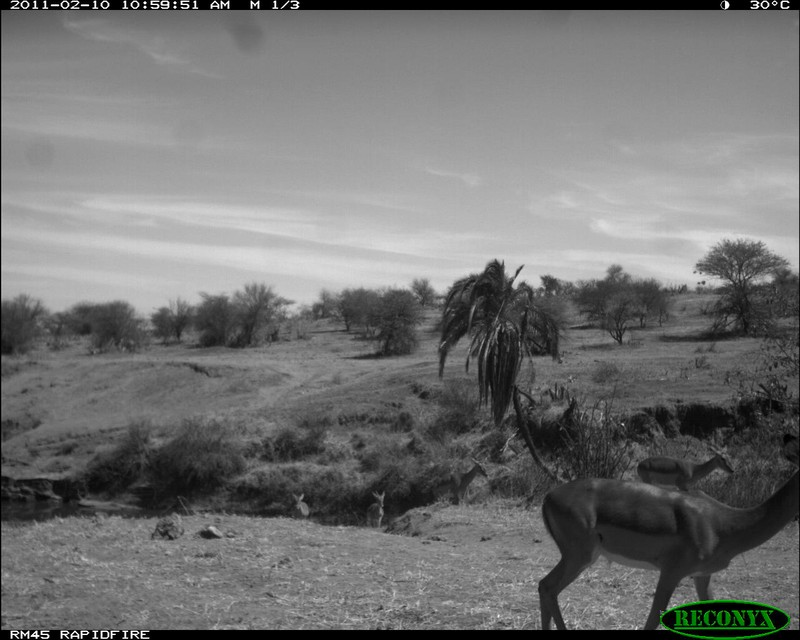

In [134]:
img_path = glob.glob(f"for_monitoring/images/{total_info_df_cut.query('location == "1495"').sample(1)['id'].values[0]}.jpg")[0]

img = Image.open(img_path).convert("RGB")
img

Только по одной фотографии сложно точно сказать (Координат локации нет), но либо это место где есть вода, либо локацией с травой, по этому данная локация в топе по визитам у животных

In [106]:
total_info_df_cut.query('location == "1495"').groupby(['date', 'pred_species_name'])['bbox'].count().unstack().fillna(0).plot()

Как мы видим вероятно антилопы использовали локацию как переходную, и мигрировали из нее  дальше

In [75]:
def map_time_of_day(datetime):
    h = datetime.hour
    if 0 <= h < 6:
        return "ночь"
    elif 6 <= h < 12:
        return "утро"
    elif 12 <= h < 18:
        return "день"
    else:
        return "вечер"

In [76]:
total_info_df_cut['time_name'] = total_info_df_cut['datetime'].map(map_time_of_day)

In [77]:
total_info_df_cut.query('location == "1495"').groupby(['time_name', 'pred_species_name'])['bbox'].count().unstack().fillna(0).plot(kind='bar')

Примичательно что на локацию приходят слоны ночью, а антилопы в дневное время

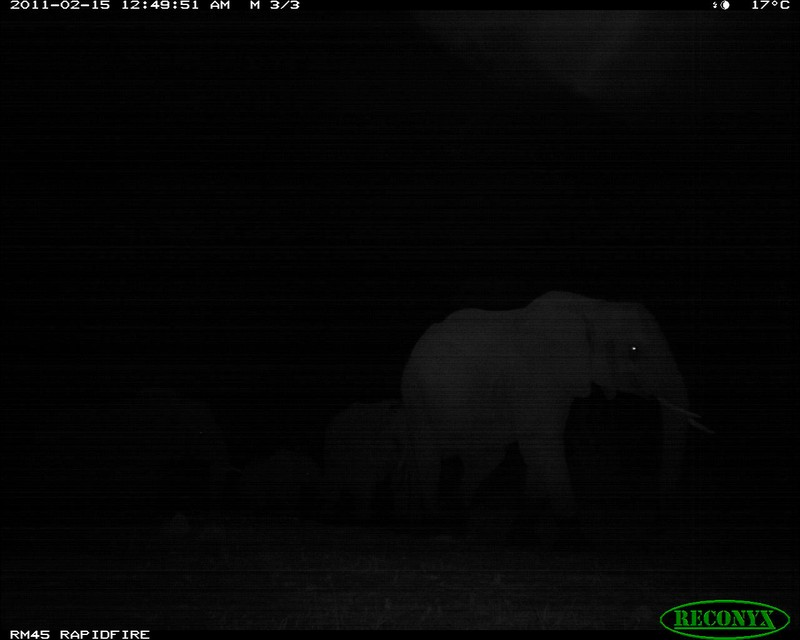

In [117]:
img_path = glob.glob(f"for_monitoring/images/{total_info_df_cut.query('location == "1495" & time_name == "ночь"').sample(1)['id'].values[0]}.jpg")[0]

img = Image.open(img_path).convert("RGB")
img

Подобный анализ позволяет точечно анализировать как и виды, так и сами локации

**Выберем локацию 1494** 

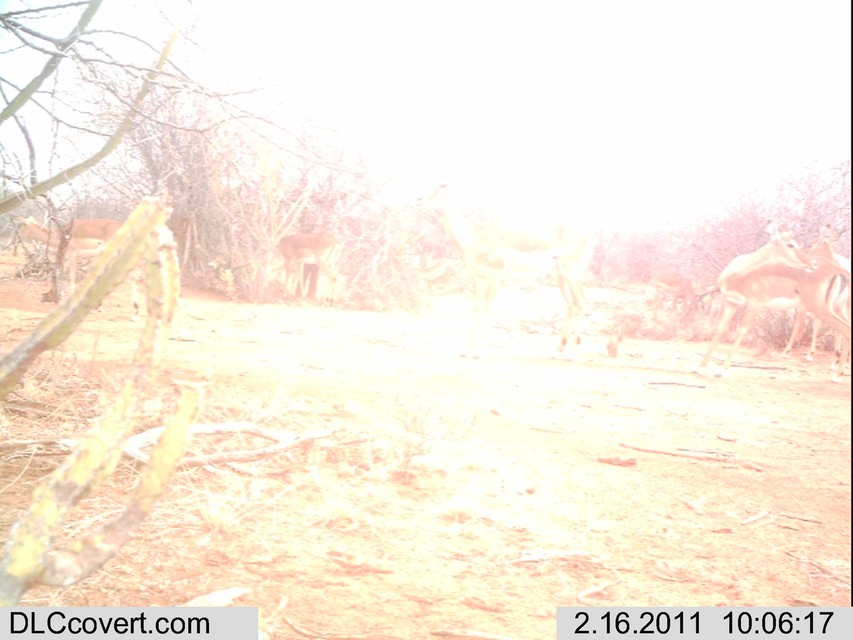

In [123]:
img_path = glob.glob(f"for_monitoring/images/{total_info_df_cut.query('location == "1494"').sample(1)['id'].values[0]}.jpg")[0]

img = Image.open(img_path).convert("RGB")
img

Данная локация сильно засвечена, однако антилоп все равно можно увидеть

In [124]:
total_info_df_cut.query('location == "1494"').groupby(['date', 'pred_species_name'])['bbox'].count().unstack().fillna(0).plot()

Как можно заметить данная точка так же выглядит промежуточным, учитывая прошлую локацию и эту, по графику визитов, можно предположить что антилопы имигрировали из прошлой локацию в эту

In [93]:
total_info_df_cut.query('location == "1494"').groupby(['time_name', 'pred_species_name'])['bbox'].count().unstack().fillna(0).plot(kind='bar')

Так же как и в прошлой локации антилопы приходят на нее в дневное/утренее время

**Анализ локаций в общем ввиде**

In [129]:
total_info_df_cut.groupby(['location', 'pred_species_name'])['bbox'].count().unstack().plot(kind='bar')

Можно заметить что разные виды антилоп используют примущественно разные локации

## Итоговые выводы

### Что в итоге собрали (end-to-end пайплайн)
- Подняли датасет wildlife_conservation_camera_trap_dataset (Hugging Face) и проверили, что картинки/лейблы валидные
- Собрали связку из двух предобученных моделей:
  - **MegaDetectorV5** — *детектор* (находит объекты и рамки bbox)
  - **BioCLIP-2** — *классификатор видов* (zero-shot: выбирает класс по текстовым названиям видов)
- Сделали **пример мониторинга** на реальных метаданных: фильтрация по датам, по `seq_id`, сбор единого датафрейма с предсказаниями, агрегации по времени и локациям

---

### Качество моделий (на test)
Получили метрики детекции:
- **precision = 0.945**
- **recall = 0.927**
- Это хорошая база для мониторинга: можно доверять факту появления/непоявления объектов

Проверили два сценария для модели класификации:</br>
**(A) Классификация по GT-рамкам (идеальный вариант рамок):**
- **accuracy = 0.744**

**(B) “End-to-end”: детектор  → классификация по детект-рамкам**
- **coverage = 0.936**
- **accuracy_on_matched = 0.763**

Интерпретация:
- Точность классификации на детект-рамках **практически не хуже**, чем на GT-рамках
- Следовательно, **детектор не является узким местом** для качества видовой классификации в этой постановке

---

### Пример мониторинга на реальных данных
- Выбрали более-менее непрерывный временной отрезок (февраль 2011) и исключили `seq_id = "unknown"`
- Собрали единый датафрейм `total_info_df` (метаданные + детекции + предсказания видов)
- Чтобы не “раздувать” события, оставили в каждом `seq_id` тот фрейм, где объектов больше всего

Дальше уже можно делать практические мониторинговые отчёты:
- динамика появлений видов по дням,
- топ-локации по активности,
- распределение по времени суток (ночь/утро/день/вечер)
- точечный анализ конкретных локаций (пример 1495 и 1494)

По наблюдениям из примера:
- можно заметить, что антилопы в конце месяца стали попадаться реже — возможно миграция (в этом коротком окне также может быть эффект объёма данных)
- локации 1495 и 1494 выглядят как “переходные” точки для антилоп
- примечательно, что слоны чаще фиксируются ночью, а антилопы — днём/утром (в примерах локаций)

---

### Что это даёт как IT-решение “мониторинга экосистемы”
На выходе получается прототип, который:
- автоматически обрабатывает поток фотоловушек,
- превращает изображения в структурированные события (кто/где/когда/с какой уверенностью),
- позволяет строить отчёты и простые алерты: “вид пропал”, “смена паттерна по времени суток”.

---

### Как можно улучшить дальше
- Обудмать более подробную предобработку фотографий, а именно фотографии с искажениями, вспышками, в ночи
- Продумать подход к тому как выбирается фрейм из набора евентов (seq_id)
- Подбор порогов det_conf и pred_conf под задачу мониторинга
- Улучшить текстовые промпты классов (латынь vs общеупотребимые английские названия), изучить как промты влияют на предикты
- При наличии мощностей и времени, дообучить модель класификатора, что бы увеличить точность, а так же возможность предсказывать и дургие классы
